In [1]:
import os
import sys
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
import scipy.sparse as sp

# Negative sample distribution

In [5]:
meta_table = pd.read_csv('../data/precessed_data/meta_table_9845.csv')
meta_table

,unified_id,kg_id,hgnc_id,symbol,entrez_id,ensembl_gene_id,uniprot_ids,refseq_accession,symbol_in_kg,biogrid_id
0,0,2,HGNC:17579,STARD3,10948,ENSG00000131748,Q14849,NM_001165937,STARD3,116148
1,1,3,HGNC:25846,PYCR3,65263,ENSG00000104524,Q53H96,NM_023078,PYCR3,122418
2,2,32774,HGNC:2734,DDX1,1653,ENSG00000079785,Q92499,NM_004939,DDX1,108019
3,3,65542,HGNC:2294,COX8A,1351,ENSG00000176340,P10176,NM_004074,COX8A,107744
4,4,65546,HGNC:14922,PLAAT1,57110,ENSG00000127252,Q9HDD0,NM_001366112,PLAAT1,121376
...,...,...,...,...,...,...,...,...,...,...
9840,9840,32747,HGNC:20947,TOMM20,9804,ENSG00000173726,Q15388,NM_014765,TOMM20,115144
9841,9841,32749,HGNC:8465,OR7G1,125962,ENSG00000161807,Q8NGA0,NM_001005192,OR7G1,125938
9842,9842,65528,HGNC:12508,UBQLN1,29979,ENSG00000135018,Q9UMX0,NM_013438,UBQLN1,119007
9843,9843,65533,HGNC:6449,KRT32,3882,ENSG00000108759,Q14532,NM_002278,KRT32,110080


In [6]:
gene_id_dict = dict(zip(meta_table['symbol'],meta_table['unified_id']))
entrez_id_dict = dict(zip(meta_table['entrez_id'],meta_table['unified_id']))
gene_set = set(meta_table['symbol'])

In [14]:
sl_label = pd.read_csv('../data/precessed_data/human_sl_9845.csv')[['unified_id_A','unified_id_B']]
sl_label

,unified_id_A,unified_id_B
0,2339,6770
1,562,6770
2,5608,6770
3,4826,6770
4,9660,6770
...,...,...
35908,325,7334
35909,2369,8732
35910,1784,4202
35911,36,7403


In [8]:
one_time_neg_index_exp = np.load('../data/precessed_data/one_time_neg_index_exp.npy',allow_pickle=True)
five_time_neg_index_exp = np.load('../data/precessed_data/five_time_neg_index_exp.npy',allow_pickle=True)
twenty_time_neg_index_exp = np.load('../data/precessed_data/twenty_time_neg_index_exp.npy',allow_pickle=True)
fifty_time_neg_index_exp = np.load('../data/precessed_data/fifty_time_neg_index_exp.npy',allow_pickle=True)

one_time_neg_index_dep = np.load('../data/precessed_data/one_time_neg_index_dep.npy',allow_pickle=True)
five_time_neg_index_dep = np.load('../data/precessed_data/five_time_neg_index_dep.npy',allow_pickle=True)
twenty_time_neg_index_dep = np.load('../data/precessed_data/twenty_time_neg_index_dep.npy',allow_pickle=True)
fifty_time_neg_index_dep = np.load('../data/precessed_data/fifty_time_neg_index_dep.npy',allow_pickle=True)

In [9]:
DepMap_Effect_corr = pd.read_csv('../data/precessed_data/DepMap_Effect_corr.csv',index_col=0)
# DepMap_Effect_corr
DepMap_Expression_corr = pd.read_csv('../data/precessed_data/DepMap_Expression_corr.csv', index_col=0)
# DepMap_Expression_corr

In [10]:
DepMap_Expression_corr.columns = DepMap_Expression_corr.columns.astype(int)
DepMap_Expression_corr.index = DepMap_Expression_corr.index.astype(int)
DepMap_Expression_corr = DepMap_Expression_corr[range(9845)]
DepMap_Expression_corr = DepMap_Expression_corr.sort_index()
DepMap_Expression_corr

,0,1,2,3,4,5,6,7,8,9,...,9835,9836,9837,9838,9839,9840,9841,9842,9843,9844
0,1.000000,0.336248,0.011864,0.102639,0.025706,0.281683,0.120356,0.007636,0.107409,0.243317,...,0.224098,0.117041,0.174449,0.156170,0.026991,-0.079476,-0.010925,0.257638,0.061204,0.204433
1,0.336248,1.000000,0.066209,0.259466,0.073096,0.324080,0.218577,-0.007688,0.254443,0.158171,...,0.126745,-0.087404,0.163639,0.320561,0.013768,-0.034115,0.009226,0.321113,0.125807,0.088811
2,0.011864,0.066209,1.000000,0.124366,0.161970,0.151995,0.284092,0.091911,0.073528,0.110446,...,-0.054027,0.061837,0.232214,0.363931,-0.019202,0.343995,0.007829,0.329342,-0.019327,-0.125282
3,0.102639,0.259466,0.124366,1.000000,0.086246,0.249411,0.257976,0.047943,-0.039321,0.038775,...,0.121475,-0.042236,-0.009486,0.330197,0.012805,0.117667,0.011157,0.147076,0.061525,-0.026629
4,0.025706,0.073096,0.161970,0.086246,1.000000,0.120416,0.090332,0.183022,0.070409,0.186490,...,0.059306,-0.135418,0.022109,0.142481,0.116534,0.150146,0.000143,0.145878,0.064714,-0.054175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9840,-0.079476,-0.034115,0.343995,0.117667,0.150146,-0.138163,0.147137,0.044384,0.021235,0.085877,...,-0.028210,0.101362,0.153829,0.138668,-0.060794,1.000000,0.033038,0.228205,-0.043823,-0.052323
9841,-0.010925,0.009226,0.007829,0.011157,0.000143,-0.022809,-0.001259,-0.018260,0.006112,-0.022484,...,0.014067,-0.021591,0.006715,-0.043636,0.046740,0.033038,1.000000,0.034097,0.007138,0.002763
9842,0.257638,0.321113,0.329342,0.147076,0.145878,0.280655,0.425947,0.110787,0.152898,0.184875,...,0.109864,0.130448,0.452231,0.477390,0.048980,0.228205,0.034097,1.000000,0.085370,-0.062251
9843,0.061204,0.125807,-0.019327,0.061525,0.064714,0.044991,-0.042876,-0.003304,0.014765,-0.006848,...,0.151038,0.002421,0.086342,0.019495,0.111320,-0.043823,0.007138,0.085370,1.000000,-0.011797


In [11]:
DepMap_Effect_corr.columns = DepMap_Effect_corr.columns.astype(int)
DepMap_Effect_corr.index = DepMap_Effect_corr.index.astype(int)
DepMap_Effect_corr

,0,1,2,3,4,5,6,7,8,9,...,9835,9836,9837,9838,9839,9840,9841,9842,9843,9844
0,1.000000,-0.048588,-0.169430,-0.019261,NaN,-0.022162,-0.073982,-0.042850,0.079718,NaN,...,-0.048925,0.013748,-0.193333,-0.026813,0.004670,-0.165333,NaN,0.035693,0.169805,-0.009529
1,-0.048588,1.000000,-0.021923,0.028501,NaN,0.012109,0.066110,-0.095528,-0.052513,NaN,...,0.063111,-0.035822,0.086421,-0.018122,0.082803,0.013617,NaN,0.008875,-0.061976,-0.017215
2,-0.169430,-0.021923,1.000000,-0.022982,NaN,0.083729,0.058292,-0.095969,-0.044042,NaN,...,0.011354,0.020620,0.306015,0.033405,-0.008934,0.192329,NaN,-0.033690,-0.040629,-0.041553
3,-0.019261,0.028501,-0.022982,1.000000,NaN,0.029759,0.057392,-0.009097,-0.048762,NaN,...,-0.022213,0.062960,0.141970,0.047474,-0.033358,-0.011963,NaN,0.000683,0.038865,-0.028459
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9840,-0.165333,0.013617,0.192329,-0.011963,NaN,-0.043205,-0.021991,-0.029793,-0.094814,NaN,...,0.016187,-0.007063,0.288092,-0.048519,0.017316,1.000000,NaN,-0.010060,-0.045679,0.023032
9841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9842,0.035693,0.008875,-0.033690,0.000683,NaN,-0.011881,0.023158,-0.051875,0.094863,NaN,...,0.047996,-0.051829,-0.041635,-0.077135,0.026003,-0.010060,NaN,1.000000,0.021645,0.109106
9843,0.169805,-0.061976,-0.040629,0.038865,NaN,-0.032142,-0.025160,0.042039,0.023137,NaN,...,-0.029908,-0.028844,-0.081907,0.003896,-0.033883,-0.045679,NaN,0.021645,1.000000,-0.006587


In [12]:
sorted_neg_ids_scores_exp = np.load('../data/precessed_data/sorted_neg_ids_scores_exp.npy')
sorted_neg_ids_scores_dep = np.load('../data/precessed_data/sorted_neg_ids_scores_dep.npy')

In [43]:
sorted_neg_ids_scores_exp

array([[ 5.49200e+03,  6.49300e+03, -8.63095e-01],
       [ 5.25800e+03,  5.49200e+03, -8.48923e-01],
       [ 6.49300e+03,  7.73900e+03, -8.29002e-01],
       ...,
       [ 3.54100e+03,  8.04400e+03,  1.00000e+00],
       [ 3.54100e+03,  7.60100e+03,  1.00000e+00],
       [ 9.23000e+02,  7.88000e+03,  1.00000e+00]])

In [44]:
sorted_neg_ids_scores_dep

array([[ 6.53000000e+02,  1.35800000e+03, -6.51346132e-01],
       [ 3.78500000e+03,  9.41700000e+03, -6.40795366e-01],
       [ 1.35800000e+03,  3.78500000e+03, -5.48099401e-01],
       ...,
       [ 2.31100000e+03,  7.11000000e+03,             nan],
       [ 6.62000000e+02,  2.78000000e+03,             nan],
       [ 9.84400000e+03,  9.84100000e+03,             nan]])

In [16]:
sl_label['exp_score'] = [DepMap_Expression_corr.loc[sl_label.iloc[i,0],sl_label.iloc[i,1]] for i in range(len(sl_label))]
sl_label['dep_score'] = [DepMap_Effect_corr.loc[sl_label.iloc[i,0],sl_label.iloc[i,1]] for i in range(len(sl_label))]
sl_label

,unified_id_A,unified_id_B,exp_score,dep_score
0,2339,6770,-0.011163,0.030836
1,562,6770,-0.042381,-0.032578
2,5608,6770,-0.024767,-0.031760
3,4826,6770,0.161234,-0.040605
4,9660,6770,-0.109860,-0.015731
...,...,...,...,...
35908,325,7334,0.043612,-0.039905
35909,2369,8732,0.092407,-0.053329
35910,1784,4202,0.541736,0.224627
35911,36,7403,0.449761,-0.040990


In [18]:
exp_df = pd.DataFrame(columns=['pnr','score'])
times = ['one','five','twenty','fifty','pos']
scores = [one_time_neg_index_exp,five_time_neg_index_exp,twenty_time_neg_index_exp,fifty_time_neg_index_exp,sl_label['exp_score'].values]
col1 = []
col2 = []
for i in range(5):
    tmpcol1 = [times[i]]*len(scores[i])
    if i==4:
        tmpcol2 = list(scores[i])
    else:
        tmpcol2 = list(sorted_neg_ids_scores_exp[scores[i],2])
    col1+=tmpcol1
    col2+=tmpcol2
exp_df['pnr'] = col1
exp_df['score'] = col2
exp_df['score'] = exp_df['score'].astype('float')

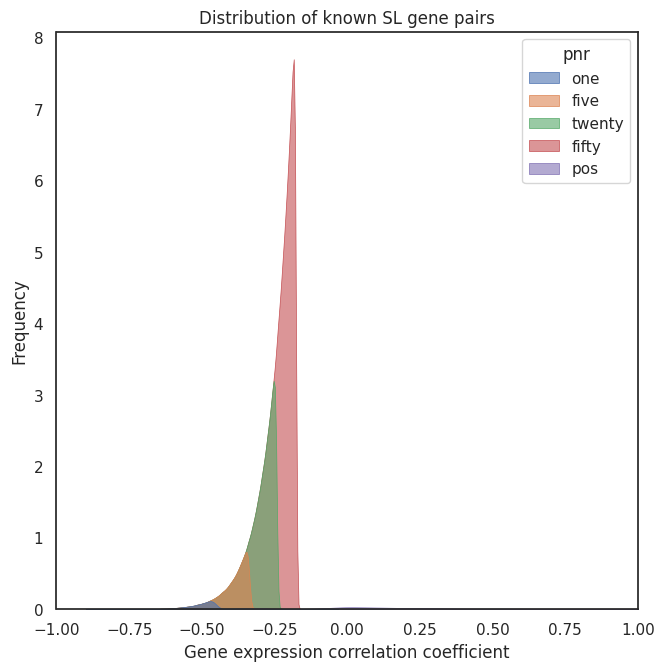

In [24]:


f,ax = plt.subplots(figsize=(7.5, 7.5))

sns.set_theme(style="white")
# Plot a histogram of the correlation
# sns.displot(data=exp_df,x='score', kind = 'kde',multiple='layer',hue = 'pnr', linewidth=0.5,alpha=.8)
# sns.kdeplot(data=np.asarray(sorted_neg_ids_scores_exp[one_time_neg_index_exp,2]), fill=True, legend=False, linewidth=0.5,alpha=.8,color=sns.color_palette("pastel")[0])
sns.kdeplot(data=exp_df,x='score',hue = 'pnr', fill=True,common_norm = False, linewidth=0.5,alpha=.6)
# sns.histplot(data=sl_corr, kde=True)

# plt.hist(sl_corr, bins=100)
plt.xlabel('Gene expression correlation coefficient')
# plt.xlabel('Gene dependency score correlation coefficient')
plt.ylabel('Frequency')
plt.title('Distribution of known SL gene pairs')
plt.xlim(-1,1)
# plt.show()

plt.savefig('sl_corr_dep_03.svg')

In [21]:
dep_df = pd.DataFrame(columns=['pnr','score'])
times = ['one','five','twenty','fifty','pos']
scores = [one_time_neg_index_dep,five_time_neg_index_dep,twenty_time_neg_index_dep,fifty_time_neg_index_dep,sl_label['dep_score'].values]
col1 = []
col2 = []
for i in range(5):
    tmpcol1 = [times[i]]*len(scores[i])
    if i==4:
        tmpcol2 = list(scores[i])
    else:
        tmpcol2 = list(sorted_neg_ids_scores_dep[scores[i],2])
    col1+=tmpcol1
    col2+=tmpcol2
dep_df['pnr'] = col1
dep_df['score'] = col2
dep_df['score'] = dep_df['score'].astype('float')
dep_df

,pnr,score
0,one,-0.651346
1,one,-0.640795
2,one,-0.548099
3,one,-0.535928
4,one,-0.533121
...,...,...
2765296,pos,-0.039905
2765297,pos,-0.053329
2765298,pos,0.224627
2765299,pos,-0.040990


(-1.0, 1.0)

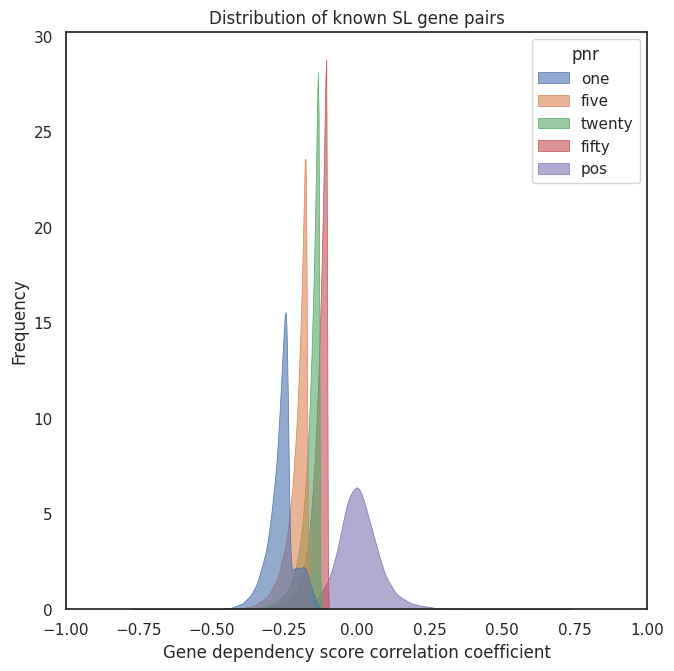

In [22]:

f,ax = plt.subplots(figsize=(7.5, 7.5))

sns.set_theme(style="white")
# Plot a histogram of the correlation
# sns.displot(data=exp_df,x='score', kind = 'kde',multiple='layer',hue = 'pnr', linewidth=0.5,alpha=.8)
# sns.kdeplot(data=np.asarray(sorted_neg_ids_scores_exp[one_time_neg_index_exp,2]), fill=True, legend=False, linewidth=0.5,alpha=.8,color=sns.color_palette("pastel")[0])
sns.kdeplot(data=dep_df,x='score',hue = 'pnr', fill=True,common_norm = False, linewidth=0.5,alpha=.6)
# sns.histplot(data=sl_corr, kde=True)

# plt.hist(sl_corr, bins=100)
# plt.xlabel('Gene expression correlation coefficient')
plt.xlabel('Gene dependency score correlation coefficient')
plt.ylabel('Frequency')
plt.title('Distribution of known SL gene pairs')
plt.xlim(-1,1)
# plt.show()

# plt.savefig('sl_corr_dep_03.svg')

# Negative sample base on gene expression

In [3]:
meta_table = pd.read_csv('../data/precessed_data/meta_table_9845.csv')
meta_table

,unified_id,kg_id,hgnc_id,symbol,entrez_id,ensembl_gene_id,uniprot_ids,refseq_accession,symbol_in_kg,biogrid_id
0,0,2,HGNC:17579,STARD3,10948,ENSG00000131748,Q14849,NM_001165937,STARD3,116148
1,1,3,HGNC:25846,PYCR3,65263,ENSG00000104524,Q53H96,NM_023078,PYCR3,122418
2,2,32774,HGNC:2734,DDX1,1653,ENSG00000079785,Q92499,NM_004939,DDX1,108019
3,3,65542,HGNC:2294,COX8A,1351,ENSG00000176340,P10176,NM_004074,COX8A,107744
4,4,65546,HGNC:14922,PLAAT1,57110,ENSG00000127252,Q9HDD0,NM_001366112,PLAAT1,121376
...,...,...,...,...,...,...,...,...,...,...
9840,9840,32747,HGNC:20947,TOMM20,9804,ENSG00000173726,Q15388,NM_014765,TOMM20,115144
9841,9841,32749,HGNC:8465,OR7G1,125962,ENSG00000161807,Q8NGA0,NM_001005192,OR7G1,125938
9842,9842,65528,HGNC:12508,UBQLN1,29979,ENSG00000135018,Q9UMX0,NM_013438,UBQLN1,119007
9843,9843,65533,HGNC:6449,KRT32,3882,ENSG00000108759,Q14532,NM_002278,KRT32,110080


In [4]:
len(set(meta_table['biogrid_id']))

9845

In [5]:
gene_id_dict = dict(zip(meta_table['symbol'],meta_table['unified_id']))
entrez_id_dict = dict(zip(meta_table['entrez_id'],meta_table['unified_id']))
gene_set = set(meta_table['symbol'])

In [5]:
DepMap_Expression = pd.read_csv('/home/yimiaofeng/Projects/DepMap/OmicsExpressionProteinCodingGenesTPMLogp1.csv',header=0,index_col=0)
# DepMap_Expression.columns = [int(g[g.index('(')+1:-1]) for g in DepMap_Expression.columns]
DepMap_Expression.columns = [g[:g.index('(')-1] for g in DepMap_Expression.columns]
DepMap_Expression

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,H3C2,H3C3,AC098582.1,DUS4L-BCAP29,C8orf44-SGK3,ELOA3B,NPBWR1,ELOA3D,ELOA3,CDR1
ACH-001113,4.331992,0.000000,7.364660,2.792855,4.471187,0.028569,1.226509,3.044394,6.500005,4.739848,...,2.689299,0.189034,0.201634,2.130931,0.555816,0.000000,0.275007,0.0,0.000000,0.000000
ACH-001289,4.567424,0.584963,7.106641,2.543496,3.504620,0.000000,0.189034,3.813525,4.221877,3.481557,...,1.286881,1.049631,0.321928,1.464668,0.632268,0.000000,0.014355,0.0,0.000000,0.000000
ACH-001339,3.150560,0.000000,7.379118,2.333424,4.228049,0.056584,1.310340,6.687201,3.682573,3.273516,...,0.594549,1.097611,0.831877,2.946731,0.475085,0.000000,0.084064,0.0,0.000000,0.042644
ACH-001538,5.085340,0.000000,7.154211,2.545968,3.084064,0.000000,5.868390,6.165309,4.489928,3.956986,...,0.214125,0.632268,0.298658,1.641546,0.443607,0.000000,0.028569,0.0,0.000000,0.000000
ACH-000242,6.729417,0.000000,6.537917,2.456806,3.867896,0.799087,7.208478,5.570159,7.127117,4.568032,...,1.117695,2.358959,0.084064,1.910733,0.000000,0.000000,0.464668,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-000285,0.056584,0.000000,6.604368,3.266037,4.973152,0.411426,0.097611,0.704872,4.829850,5.178715,...,2.229588,0.084064,1.310340,3.039138,0.344828,0.000000,0.000000,0.0,0.475085,0.042644
ACH-002669,3.111031,0.000000,7.031329,1.541019,3.664483,0.014355,3.624101,6.805421,4.472488,4.397118,...,0.189034,0.400538,0.356144,1.327687,0.000000,0.000000,0.014355,0.0,0.000000,0.000000
ACH-001858,4.390943,0.000000,7.013239,1.887525,3.252476,0.028569,3.286881,6.902194,5.410748,3.401903,...,1.097611,0.400538,0.613532,1.992768,0.704872,0.000000,1.464668,0.0,0.000000,0.526069
ACH-001997,5.057450,0.000000,7.815191,2.538538,3.893362,0.028569,4.079805,6.971659,4.469886,3.463361,...,0.831877,0.847997,1.292782,2.153805,0.687061,0.000000,0.000000,0.0,0.000000,0.000000


In [6]:
DepMap_Expression = DepMap_Expression[list(set(DepMap_Expression.columns)&(set(meta_table['symbol_in_kg'])|set(meta_table['symbol'])))]
DepMap_Expression

,H4C8,TIMM9,PARD6A,CEP70,TRIM25,RBM14,ATP6V1D,NUP58,CRISP2,CNNM3,...,FEZF2,CEP152,UBR7,GPN2,PTOV1,LLGL1,CNTN6,TMED9,IFNGR2,SRP54
ACH-001113,5.604664,6.628919,0.214125,4.788164,5.275380,4.495056,6.697802,5.198101,0.000000,3.211012,...,0.0,3.478972,4.881175,3.411426,5.743353,4.044394,0.000000,7.832004,6.002703,6.588565
ACH-001289,4.676380,6.581954,3.845992,4.950935,4.006298,5.189429,7.483574,5.000901,0.000000,3.674687,...,0.0,2.204767,5.355439,3.715893,6.786466,3.582556,0.014355,6.954429,5.576824,6.347134
ACH-001339,2.498251,6.107897,0.910733,4.787119,4.679199,4.316870,6.469072,5.848247,0.000000,2.521051,...,0.0,3.130931,4.334139,4.170726,5.445925,3.000000,1.028569,7.618679,7.529821,5.511595
ACH-001538,1.469886,6.656925,1.627607,5.193772,4.790772,4.135042,6.326969,4.796494,0.028569,1.948601,...,0.0,2.505891,4.136684,4.040892,5.793116,2.925999,0.000000,6.676944,6.096557,6.287805
ACH-000242,1.339137,6.150966,2.185867,4.242603,5.441284,5.815832,5.883132,4.533563,0.000000,3.463361,...,0.0,2.910733,5.208283,3.370164,6.761684,3.555816,0.124328,7.285587,5.296824,5.909293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-000285,2.817623,6.029453,3.017922,4.524816,5.996389,5.926474,4.914086,5.732269,0.000000,3.952334,...,0.0,4.493775,5.879951,3.841973,5.675534,3.989139,0.000000,6.597233,6.659782,5.978882
ACH-002669,2.627607,6.786335,2.347666,4.889474,5.124742,4.207112,7.030005,5.216455,0.000000,2.815575,...,0.0,2.831877,4.521679,3.673556,5.754086,2.185867,0.000000,7.466627,5.878235,6.014578
ACH-001858,2.003602,5.398829,0.214125,4.275752,4.633431,4.666188,6.406162,4.392317,0.000000,2.327687,...,0.0,2.646163,3.618239,3.477677,6.220136,5.231509,0.000000,7.424838,5.122259,6.024142
ACH-001997,2.879706,6.281142,3.246408,3.267536,5.469235,4.365972,6.603923,4.297925,0.000000,3.794936,...,0.0,2.107688,4.994580,3.823749,6.091488,4.051372,0.432959,6.035184,2.871844,6.078524


In [6]:
gene_list =  list(set(DepMap_Expression.columns)&(set(meta_table['symbol_in_kg'])|set(meta_table['symbol'])))
symbol_in_kg_id = dict(zip(meta_table['symbol_in_kg'], meta_table['unified_id']))
symbol_id = dict(zip(meta_table['symbol'], meta_table['unified_id']))

NameError: name 'DepMap_Expression' is not defined

In [8]:
len(set([symbol_in_kg_id[g] for g in gene_list if g in symbol_in_kg_id.keys()])|set([symbol_id[g] for g in gene_list if g in symbol_id.keys()]))
all_ids = {}
for g in DepMap_Expression.columns:
    if g in symbol_in_kg_id.keys():
        all_ids[g] = symbol_in_kg_id[g]
        continue
    if g in symbol_id.keys():
        all_ids[g] = symbol_id[g]
        continue
print(len(all_ids))

9828


In [9]:
len(set(DepMap_Expression.columns.map(all_ids)))

9828

In [10]:
DepMap_Expression.columns = DepMap_Expression.columns.map(all_ids)
DepMap_Expression = DepMap_Expression[sorted(DepMap_Expression.columns)]
DepMap_Expression = DepMap_Expression.T
# DepMap_Expression = meta_table[['unified_id','symbol_in_kg']].merge(DepMap_Expression,left_on='symbol_in_kg',right_index=True,how='inner')
# DepMap_Expression = DepMap_Expression[DepMap_Expression.columns[2:]]
DepMap_Expression

,ACH-001113,ACH-001289,ACH-001339,ACH-001538,ACH-000242,ACH-000708,ACH-000327,ACH-000233,ACH-000461,ACH-000705,...,ACH-001578,ACH-000036,ACH-000973,ACH-001128,ACH-000750,ACH-000285,ACH-002669,ACH-001858,ACH-001997,ACH-000052
0,4.587365,4.436961,4.811471,4.916477,5.274262,3.423578,4.112700,6.178715,6.050502,5.789729,...,4.788686,5.871104,5.382321,5.762349,6.176123,5.145677,4.549669,4.889960,5.850999,4.409391
1,2.257011,2.634593,2.260026,2.687061,3.711495,4.136684,3.442280,2.100978,3.748461,3.480265,...,1.929791,2.855990,4.000000,3.827819,3.777157,4.669594,2.594549,3.752749,3.688180,4.584963
2,7.668176,7.177320,7.343585,7.170726,6.513333,6.493775,6.975217,5.946731,6.144454,7.744498,...,6.944273,6.248497,7.297650,6.586014,6.797013,6.390083,6.542103,6.509538,6.035624,6.671010
3,8.943101,9.268051,8.963532,9.287805,9.346336,8.705874,9.379032,8.594287,9.765468,8.695402,...,9.444352,9.100741,9.659157,9.025693,9.357926,8.536286,9.002337,9.788930,9.725128,9.860435
4,1.389567,2.560715,0.201634,0.992768,0.000000,0.000000,2.253989,2.655352,0.084064,1.948601,...,3.125982,1.819668,0.070389,0.000000,1.855990,0.000000,2.153805,2.543496,0.000000,0.422233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9840,7.443938,7.413289,7.093919,7.905748,6.731998,6.838574,6.844109,7.546046,5.921722,7.172528,...,7.869008,6.296641,6.484460,7.555126,6.603626,7.644000,6.264724,7.058858,7.004838,6.015248
9841,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9842,6.509221,6.560256,5.678917,6.624393,5.227279,6.193772,5.214125,5.739848,6.667750,6.352088,...,5.764208,6.076174,6.333960,6.249256,6.329841,6.384223,5.495056,6.584061,5.957915,6.419033
9843,0.189034,0.000000,0.070389,0.176323,0.000000,0.000000,0.028569,0.014355,0.000000,0.042644,...,0.000000,0.163499,0.000000,0.000000,0.176323,0.000000,0.014355,0.124328,0.201634,0.150560


In [11]:
len(set(DepMap_Expression.index))

9828

In [12]:
DepMap_Expression_corr = DepMap_Expression.T.corr()

In [13]:
DepMap_Expression_corr

,0,1,2,3,4,5,6,7,8,9,...,9835,9836,9837,9838,9839,9840,9841,9842,9843,9844
0,1.000000,0.336248,0.011864,0.102639,0.025706,0.281683,0.120356,0.007636,0.107409,0.243317,...,0.224098,0.117041,0.174449,0.156170,0.026991,-0.079476,-0.010925,0.257638,0.061204,0.204433
1,0.336248,1.000000,0.066209,0.259466,0.073096,0.324080,0.218577,-0.007688,0.254443,0.158171,...,0.126745,-0.087404,0.163639,0.320561,0.013768,-0.034115,0.009226,0.321113,0.125807,0.088811
2,0.011864,0.066209,1.000000,0.124366,0.161970,0.151995,0.284092,0.091911,0.073528,0.110446,...,-0.054027,0.061837,0.232214,0.363931,-0.019202,0.343995,0.007829,0.329342,-0.019327,-0.125282
3,0.102639,0.259466,0.124366,1.000000,0.086246,0.249411,0.257976,0.047943,-0.039321,0.038775,...,0.121475,-0.042236,-0.009486,0.330197,0.012805,0.117667,0.011157,0.147076,0.061525,-0.026629
4,0.025706,0.073096,0.161970,0.086246,1.000000,0.120416,0.090332,0.183022,0.070409,0.186490,...,0.059306,-0.135418,0.022109,0.142481,0.116534,0.150146,0.000143,0.145878,0.064714,-0.054175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9840,-0.079476,-0.034115,0.343995,0.117667,0.150146,-0.138163,0.147137,0.044384,0.021235,0.085877,...,-0.028210,0.101362,0.153829,0.138668,-0.060794,1.000000,0.033038,0.228205,-0.043823,-0.052323
9841,-0.010925,0.009226,0.007829,0.011157,0.000143,-0.022809,-0.001259,-0.018260,0.006112,-0.022484,...,0.014067,-0.021591,0.006715,-0.043636,0.046740,0.033038,1.000000,0.034097,0.007138,0.002763
9842,0.257638,0.321113,0.329342,0.147076,0.145878,0.280655,0.425947,0.110787,0.152898,0.184875,...,0.109864,0.130448,0.452231,0.477390,0.048980,0.228205,0.034097,1.000000,0.085370,-0.062251
9843,0.061204,0.125807,-0.019327,0.061525,0.064714,0.044991,-0.042876,-0.003304,0.014765,-0.006848,...,0.151038,0.002421,0.086342,0.019495,0.111320,-0.043823,0.007138,0.085370,1.000000,-0.011797


In [13]:
sl_label = pd.read_csv('../data/precessed_data/human_sl_9845.csv')[['unified_id_A','unified_id_B']]
sl_label

,unified_id_A,unified_id_B
0,2339,6770
1,562,6770
2,5608,6770
3,4826,6770
4,9660,6770
...,...,...
35908,325,7334
35909,2369,8732
35910,1784,4202
35911,36,7403


In [15]:
missing_gene = list(set(range(9845))-set(DepMap_Expression_corr.columns))
len(missing_gene)

17

In [16]:
DepMap_Expression_corr.loc[:,missing_gene] = np.ones((DepMap_Expression_corr.shape[0],len(missing_gene)))
DepMap_Expression_corr = pd.concat([DepMap_Expression_corr,pd.DataFrame(np.ones((len(missing_gene),DepMap_Expression_corr.shape[1])),columns=DepMap_Expression_corr.columns,index=missing_gene)])
DepMap_Expression_corr

,0,1,2,3,4,5,6,7,8,9,...,8015,3668,437,3541,3862,8822,4186,5979,2364,3327
0,1.000000,0.336248,0.011864,0.102639,0.025706,0.281683,0.120356,0.007636,0.107409,0.243317,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.336248,1.000000,0.066209,0.259466,0.073096,0.324080,0.218577,-0.007688,0.254443,0.158171,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.011864,0.066209,1.000000,0.124366,0.161970,0.151995,0.284092,0.091911,0.073528,0.110446,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.102639,0.259466,0.124366,1.000000,0.086246,0.249411,0.257976,0.047943,-0.039321,0.038775,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.025706,0.073096,0.161970,0.086246,1.000000,0.120416,0.090332,0.183022,0.070409,0.186490,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8822,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4186,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5979,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2364,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [17]:
DepMap_Expression_corr.to_csv('DepMap_Expression_corr.csv', float_format='%.6f')

In [16]:
DepMap_Expression_corr = pd.read_csv('../data/precessed_data/DepMap_Expression_corr.csv', index_col=0)
DepMap_Expression_corr

,0,1,2,3,4,5,6,7,8,9,...,8015,3668,437,3541,3862,8822,4186,5979,2364,3327
0,1.000000,0.336248,0.011864,0.102639,0.025706,0.281683,0.120356,0.007636,0.107409,0.243317,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.336248,1.000000,0.066209,0.259466,0.073096,0.324080,0.218577,-0.007688,0.254443,0.158171,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.011864,0.066209,1.000000,0.124366,0.161970,0.151995,0.284092,0.091911,0.073528,0.110446,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.102639,0.259466,0.124366,1.000000,0.086246,0.249411,0.257976,0.047943,-0.039321,0.038775,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.025706,0.073096,0.161970,0.086246,1.000000,0.120416,0.090332,0.183022,0.070409,0.186490,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8822,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4186,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5979,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2364,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [18]:
DepMap_Expression_corr.columns = DepMap_Expression_corr.columns.astype(int)
DepMap_Expression_corr.index = DepMap_Expression_corr.index.astype(int)
DepMap_Expression_corr = DepMap_Expression_corr[range(9845)]
DepMap_Expression_corr = DepMap_Expression_corr.sort_index()
DepMap_Expression_corr

,0,1,2,3,4,5,6,7,8,9,...,9835,9836,9837,9838,9839,9840,9841,9842,9843,9844
0,1.000000,0.336248,0.011864,0.102639,0.025706,0.281683,0.120356,0.007636,0.107409,0.243317,...,0.224098,0.117041,0.174449,0.156170,0.026991,-0.079476,-0.010925,0.257638,0.061204,0.204433
1,0.336248,1.000000,0.066209,0.259466,0.073096,0.324080,0.218577,-0.007688,0.254443,0.158171,...,0.126745,-0.087404,0.163639,0.320561,0.013768,-0.034115,0.009226,0.321113,0.125807,0.088811
2,0.011864,0.066209,1.000000,0.124366,0.161970,0.151995,0.284092,0.091911,0.073528,0.110446,...,-0.054027,0.061837,0.232214,0.363931,-0.019202,0.343995,0.007829,0.329342,-0.019327,-0.125282
3,0.102639,0.259466,0.124366,1.000000,0.086246,0.249411,0.257976,0.047943,-0.039321,0.038775,...,0.121475,-0.042236,-0.009486,0.330197,0.012805,0.117667,0.011157,0.147076,0.061525,-0.026629
4,0.025706,0.073096,0.161970,0.086246,1.000000,0.120416,0.090332,0.183022,0.070409,0.186490,...,0.059306,-0.135418,0.022109,0.142481,0.116534,0.150146,0.000143,0.145878,0.064714,-0.054175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9840,-0.079476,-0.034115,0.343995,0.117667,0.150146,-0.138163,0.147137,0.044384,0.021235,0.085877,...,-0.028210,0.101362,0.153829,0.138668,-0.060794,1.000000,0.033038,0.228205,-0.043823,-0.052323
9841,-0.010925,0.009226,0.007829,0.011157,0.000143,-0.022809,-0.001259,-0.018260,0.006112,-0.022484,...,0.014067,-0.021591,0.006715,-0.043636,0.046740,0.033038,1.000000,0.034097,0.007138,0.002763
9842,0.257638,0.321113,0.329342,0.147076,0.145878,0.280655,0.425947,0.110787,0.152898,0.184875,...,0.109864,0.130448,0.452231,0.477390,0.048980,0.228205,0.034097,1.000000,0.085370,-0.062251
9843,0.061204,0.125807,-0.019327,0.061525,0.064714,0.044991,-0.042876,-0.003304,0.014765,-0.006848,...,0.151038,0.002421,0.086342,0.019495,0.111320,-0.043823,0.007138,0.085370,1.000000,-0.011797


In [7]:
DepMap_Expression_corr.columns = meta_table.loc[DepMap_Expression_corr.columns,'symbol'].values
DepMap_Expression_corr.index = meta_table.loc[DepMap_Expression_corr.index,'symbol'].values
DepMap_Expression_corr

,STARD3,PYCR3,DDX1,COX8A,PLAAT1,GPS2,CDCA2,KCND3,RIOX2,KRBA1,...,PPP1R3D,B3GNT2,RAD50,TUBA1B,TP53AIP1,TOMM20,OR7G1,UBQLN1,KRT32,LTC4S
STARD3,1.000000,0.336248,0.011864,0.102639,0.025706,0.281683,0.120356,0.007636,0.107409,0.243317,...,0.224098,0.117041,0.174449,0.156170,0.026991,-0.079476,-0.010925,0.257638,0.061204,0.204433
PYCR3,0.336248,1.000000,0.066209,0.259466,0.073096,0.324080,0.218577,-0.007688,0.254443,0.158171,...,0.126745,-0.087404,0.163639,0.320561,0.013768,-0.034115,0.009226,0.321113,0.125807,0.088811
DDX1,0.011864,0.066209,1.000000,0.124366,0.161970,0.151995,0.284092,0.091911,0.073528,0.110446,...,-0.054027,0.061837,0.232214,0.363931,-0.019202,0.343995,0.007829,0.329342,-0.019327,-0.125282
COX8A,0.102639,0.259466,0.124366,1.000000,0.086246,0.249411,0.257976,0.047943,-0.039321,0.038775,...,0.121475,-0.042236,-0.009486,0.330197,0.012805,0.117667,0.011157,0.147076,0.061525,-0.026629
PLAAT1,0.025706,0.073096,0.161970,0.086246,1.000000,0.120416,0.090332,0.183022,0.070409,0.186490,...,0.059306,-0.135418,0.022109,0.142481,0.116534,0.150146,0.000143,0.145878,0.064714,-0.054175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TOMM20,-0.079476,-0.034115,0.343995,0.117667,0.150146,-0.138163,0.147137,0.044384,0.021235,0.085877,...,-0.028210,0.101362,0.153829,0.138668,-0.060794,1.000000,0.033038,0.228205,-0.043823,-0.052323
OR7G1,-0.010925,0.009226,0.007829,0.011157,0.000143,-0.022809,-0.001259,-0.018260,0.006112,-0.022484,...,0.014067,-0.021591,0.006715,-0.043636,0.046740,0.033038,1.000000,0.034097,0.007138,0.002763
UBQLN1,0.257638,0.321113,0.329342,0.147076,0.145878,0.280655,0.425947,0.110787,0.152898,0.184875,...,0.109864,0.130448,0.452231,0.477390,0.048980,0.228205,0.034097,1.000000,0.085370,-0.062251
KRT32,0.061204,0.125807,-0.019327,0.061525,0.064714,0.044991,-0.042876,-0.003304,0.014765,-0.006848,...,0.151038,0.002421,0.086342,0.019495,0.111320,-0.043823,0.007138,0.085370,1.000000,-0.011797


In [8]:
DepMap_Expression_corr = DepMap_Expression_corr.sort_index()
DepMap_Expression_corr = DepMap_Expression_corr.T.sort_index().T
DepMap_Expression_corr

,A1BG,A2M,A2ML1,AADAC,AADACL2,AADAT,AAMP,AANAT,AAR2,AARD,...,ZSCAN26,ZSCAN9,ZSWIM1,ZSWIM2,ZSWIM8,ZWILCH,ZWINT,ZXDC,ZYX,ZZZ3
A1BG,1.000000,0.142552,-0.168476,-0.250454,-0.008916,0.072702,0.000988,0.023150,0.072335,0.218314,...,0.315634,0.094514,0.032966,0.144996,0.255086,0.053462,0.061774,0.113754,-0.002197,0.055746
A2M,0.142552,1.000000,-0.107198,-0.083857,-0.029038,0.178576,0.074401,-0.091333,0.111108,0.130183,...,0.134330,0.002583,-0.084918,0.101482,0.158673,0.020712,-0.094281,-0.022163,0.125785,0.123496
A2ML1,-0.168476,-0.107198,1.000000,0.082589,0.188433,-0.068125,-0.098257,0.011917,-0.045025,-0.032427,...,-0.192502,-0.085788,0.020341,-0.029113,-0.060050,-0.172949,-0.164075,0.029650,-0.042337,-0.142036
AADAC,-0.250454,-0.083857,0.082589,1.000000,0.061695,0.005607,0.048542,0.007793,0.020673,-0.132349,...,-0.113781,-0.024714,0.070932,-0.044581,-0.006058,-0.029240,-0.077894,0.015265,0.098145,-0.017507
AADACL2,-0.008916,-0.029038,0.188433,0.061695,1.000000,0.018330,-0.013450,-0.001127,0.049662,-0.017877,...,0.027866,0.030408,0.065715,0.010880,0.031805,-0.015948,-0.040673,0.058654,-0.068295,-0.013362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZWILCH,0.053462,0.020712,-0.172949,-0.029240,-0.015948,0.273755,0.310357,0.033238,0.366636,0.054203,...,0.245643,0.067446,0.245731,0.093955,-0.000722,1.000000,0.631745,0.164557,0.014069,0.409541
ZWINT,0.061774,-0.094281,-0.164075,-0.077894,-0.040673,0.168890,0.341898,0.002150,0.296057,0.099578,...,0.134890,0.103464,0.331075,0.075789,0.153175,0.631745,1.000000,0.298314,-0.077687,0.237324
ZXDC,0.113754,-0.022163,0.029650,0.015265,0.058654,0.141628,0.300697,0.134347,0.312058,0.046912,...,0.180919,0.180268,0.529728,0.078948,0.318455,0.164557,0.298314,1.000000,-0.136049,0.226500
ZYX,-0.002197,0.125785,-0.042337,0.098145,-0.068295,0.143757,0.114432,-0.175067,0.092229,0.004897,...,0.103721,0.094644,-0.052183,-0.016393,0.193461,0.014069,-0.077687,-0.136049,1.000000,0.032213


In [ ]:
DepMap_Expression_corr.to_csv('DepMap_Expression_corr.csv', float_format='%.6f')

In [38]:
sl_mat = sp.csc_matrix((np.ones(len(sl_label)), (sl_label['unified_id_A'], sl_label['unified_id_B'])), shape=(9845, 9845))
sl_mat = sl_mat+sl_mat.T
sl_mat = sl_mat.toarray()
neg_mat = np.ones((9845, 9845))
neg_wo_sl_mat = neg_mat - sl_mat
neg_wo_sl_up = np.triu(neg_wo_sl_mat,k=1)
neg_wo_sl_up = sp.csc_matrix(neg_wo_sl_up*DepMap_Expression_corr.values)
neg_ids = np.vstack(neg_wo_sl_up.nonzero()).T
neg_ids

array([[   0,    1],
       [   0,    2],
       [   0,    3],
       ...,
       [9842, 9843],
       [9842, 9844],
       [9843, 9844]], dtype=int32)

In [39]:
corr_scores = np.asarray(DepMap_Expression_corr.values)[neg_ids[:,0],neg_ids[:,1]]
neg_ids_scores = np.vstack([neg_ids.T,corr_scores]).T
neg_ids_scores
# corr_scores

array([[ 0.00000e+00,  1.00000e+00,  3.36248e-01],
       [ 0.00000e+00,  2.00000e+00,  1.18640e-02],
       [ 0.00000e+00,  3.00000e+00,  1.02639e-01],
       ...,
       [ 9.84200e+03,  9.84300e+03,  8.53700e-02],
       [ 9.84200e+03,  9.84400e+03, -6.22510e-02],
       [ 9.84300e+03,  9.84400e+03, -1.17970e-02]])

In [40]:
sorted_indices = np.argsort(neg_ids_scores[:, 2])
sorted_neg_ids_scores = neg_ids_scores[sorted_indices]
sorted_neg_ids_scores

array([[ 5.49200e+03,  6.49300e+03, -8.63095e-01],
       [ 5.25800e+03,  5.49200e+03, -8.48923e-01],
       [ 6.49300e+03,  7.73900e+03, -8.29002e-01],
       ...,
       [ 3.54100e+03,  8.04400e+03,  1.00000e+00],
       [ 3.54100e+03,  7.60100e+03,  1.00000e+00],
       [ 9.23000e+02,  7.88000e+03,  1.00000e+00]])

In [18]:
np.save('sorted_neg_ids_scores.npy',sorted_neg_ids_scores)

In [41]:
contained_genes = set()
contained_neg_pairs_index = []
index_neg_pair = 0
while len(contained_genes) < 9828:
    if len(set(sorted_neg_ids_scores[index_neg_pair, :2]) & contained_genes) < 2:
        contained_neg_pairs_index.append(index_neg_pair)
        contained_genes = contained_genes | set(sorted_neg_ids_scores[index_neg_pair, :2])
    index_neg_pair+=1

In [44]:
top5 = sorted_neg_ids_scores[contained_neg_pairs_index[-5:],:]
top5 = pd.DataFrame(top5,columns=['unified_id_A','unified_id_B','corr_score'])
top5['symbol_A'] = top5['unified_id_A'].map(meta_table.set_index('unified_id')['symbol'])
top5['symbol_B'] = top5['unified_id_B'].map(meta_table.set_index('unified_id')['symbol'])
top5

,unified_id_A,unified_id_B,corr_score,symbol_A,symbol_B
0,666.0,7573.0,-0.078863,OR7A10,MRPS21
1,3569.0,6249.0,-0.074603,CCNDBP1,OR5M9
2,8923.0,9409.0,-0.072366,TDP1,OR1I1
3,3397.0,9432.0,-0.070855,TMLHE,KRTAP19-7
4,488.0,5949.0,-0.067444,POLB,OR4S1


In [43]:
len(contained_neg_pairs_index)

9770

In [36]:
one_time_neg_index = copy.deepcopy(contained_neg_pairs_index)
five_time_neg_index = copy.deepcopy(contained_neg_pairs_index)
twinty_time_neg_index = copy.deepcopy(contained_neg_pairs_index)
fifty_time_neg_index = copy.deepcopy(contained_neg_pairs_index)
index_neg_pair = 0
while len(one_time_neg_index) < len(sl_label):
    if index_neg_pair not in one_time_neg_index:
        one_time_neg_index.append(index_neg_pair)
    index_neg_pair+=1
index_neg_pair = 0
while len(five_time_neg_index) < len(sl_label)*5:
    if index_neg_pair not in five_time_neg_index:
        five_time_neg_index.append(index_neg_pair)
    index_neg_pair+=1
index_neg_pair = 0
while len(twinty_time_neg_index) < len(sl_label)*20:
    if index_neg_pair not in twinty_time_neg_index:
        twinty_time_neg_index.append(index_neg_pair)
    index_neg_pair+=1
index_neg_pair = 0
while len(fifty_time_neg_index) < len(sl_label)*50:
    if index_neg_pair not in fifty_time_neg_index:
        fifty_time_neg_index.append(index_neg_pair)
    index_neg_pair+=1

In [37]:
np.save('one_time_neg_index_exp.npy', one_time_neg_index)
np.save('five_time_neg_index_exp.npy', five_time_neg_index)
np.save('twenty_time_neg_index_exp.npy', twinty_time_neg_index)
np.save('fifty_time_neg_index_exp.npy', fifty_time_neg_index)

In [39]:
sorted_neg_ids_scores[index_neg_pair,:]

array([ 1.23500e+03,  2.46700e+03, -1.76217e-01])

In [17]:
len(set(one_time[:,0])|set(one_time[:,1]))

2285

In [8]:
sl_corr = np.zeros((len(sl_label),1))
not_in = 0
for i in range(len(sl_label)):
    a, b = sl_label.iloc[i,:]
    sl_corr[i] = DepMap_Expression_corr.loc[a,b]
    if sl_corr[i] == 1:
        sl_corr[i] = 2

# Plot a histogram of the correlation
# sns.histplot(data=sl_corr)

# plt.hist(sl_corr, bins=100)
# plt.xlabel('Value')
# plt.ylabel('Frequency')                                                                                                                                                                                                                                 
# plt.title('Histogram of List Values')
# plt.show()

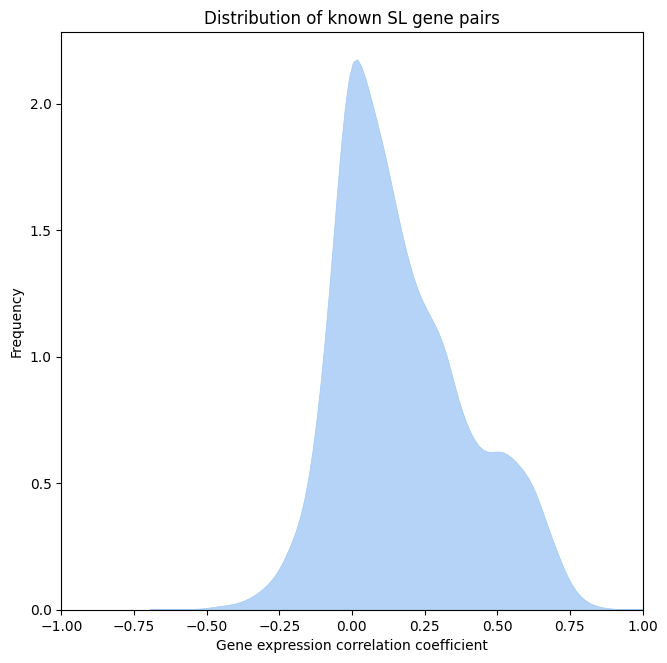

In [12]:
f,ax = plt.subplots(figsize=(7.5, 7.5))

# Plot a histogram of the correlation
sns.kdeplot(data=sl_corr, fill=True, legend=False, linewidth=0.5,palette="pastel",alpha=.8)
# sns.histplot(data=sl_corr, kde=True)

# plt.hist(sl_corr, bins=100)
plt.xlabel('Gene expression correlation coefficient')
plt.ylabel('Frequency')
plt.title('Distribution of known SL gene pairs')
plt.xlim(-1,1)
# plt.show()
plt.savefig('sl_corr_exp_18.svg')

# Negative sample base on gene dependency score

In [40]:
DepMap_Effect = pd.read_csv('/home/yimiaofeng/Projects/DepMap/CRISPRGeneEffect.csv',header = 0,index_col=0)
DepMap_Effect.columns = [g[:g.index('(')-1] for g in DepMap_Effect.columns]
DepMap_Effect

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
ACH-000004,0.014633,-0.032777,-0.151299,-0.071388,0.046511,-0.162850,0.290698,-0.240991,0.176710,0.159418,...,-0.188857,-0.389649,0.112266,-0.002883,0.155729,0.077283,-0.294451,0.143978,0.197069,-0.003338
ACH-000005,-0.261566,0.174833,0.106526,0.135635,-0.076753,-0.278640,0.239279,-0.325967,-0.116848,0.022227,...,-0.195492,-0.360578,-0.126277,-0.059287,0.080543,-0.161894,-0.070230,-0.006275,0.002458,0.014259
ACH-000007,-0.028717,-0.117017,0.030971,0.083795,0.032668,-0.035709,0.012355,-0.192436,-0.077174,0.164877,...,-0.200402,-0.382707,0.006843,0.199553,0.064425,-0.031683,-0.291406,-0.065945,-0.260946,-0.329018
ACH-000009,0.000225,-0.283124,0.051248,0.120321,0.022834,-0.077522,0.028013,-0.190495,0.031589,0.043242,...,-0.179775,-0.285412,-0.029599,0.227176,-0.097506,-0.136990,-0.421927,0.050002,-0.107675,-0.249623
ACH-000011,0.095791,-0.099622,0.022204,0.199771,-0.048126,-0.290812,-0.013277,-0.095840,0.090307,0.029379,...,-0.671885,-0.558008,0.020997,0.011011,0.206251,0.086453,-0.166360,-0.055975,-0.159886,-0.311232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-002296,-0.073879,0.046252,-0.077086,0.028623,-0.000662,0.003801,0.023230,-1.143038,0.004579,0.115898,...,0.135984,-0.666816,0.015930,-0.000437,0.157030,-0.054452,-0.260831,0.064285,0.041468,-0.428699
ACH-002297,0.084735,-0.249753,0.045093,0.070714,-0.194074,-0.038278,-0.029772,-0.743310,0.081368,0.155969,...,-0.407122,-0.473605,-0.000171,0.153230,-0.066343,0.029340,-0.120501,-0.058169,-0.179429,-0.172884
ACH-002298,-0.172365,-0.112164,0.055771,-0.017571,-0.010154,-0.069917,-0.092145,-0.135460,0.008202,-0.132641,...,-0.270696,-0.383323,0.101514,0.101316,0.110317,-0.006500,-0.158971,-0.114161,0.128512,-0.267323
ACH-002304,-0.033065,0.171028,-0.044622,0.185127,0.063611,-0.047573,0.118359,-0.571989,-0.101702,0.263272,...,0.106406,-0.300325,-0.034307,-0.176315,-0.054927,-0.079415,-0.130105,0.133510,-0.126235,-0.211761


In [43]:
DepMap_Effect = DepMap_Effect[list(set(DepMap_Effect.columns)&(set(meta_table['symbol_in_kg'])|set(meta_table['symbol'])))]
DepMap_Effect

,RASSF3,SUV39H2,ESRP2,MRPS18C,C7orf31,L2HGDH,NOC3L,TOPAZ1,NAGS,PHLDA1,...,GNA14,EHD4,HUS1,EIF4E3,PTPN21,RPP25L,DDO,BDNF,BCL2L1,RXFP3
ACH-000004,0.073388,0.053576,-0.016867,-0.131008,0.126009,0.051803,-0.613855,0.151776,0.210020,0.025473,...,-0.083562,-0.086553,-1.644745,-0.026726,-0.003050,-1.150396,0.140655,-0.038311,-2.437201,-0.032732
ACH-000005,0.254138,-0.069973,-0.036116,0.114206,-0.103548,-0.246073,-1.005879,0.004864,-0.073720,-0.117771,...,-0.015408,-0.200994,-1.062638,-0.131163,-0.369532,-1.021107,0.127879,-0.175678,-2.014112,0.088781
ACH-000007,0.005561,-0.061581,-0.236218,-0.308507,-0.044326,0.088700,-0.711611,0.096580,0.162837,0.094481,...,0.045601,0.139582,-0.772101,0.045053,-0.061524,-0.122670,0.070429,-0.224055,-1.395974,-0.178735
ACH-000009,0.225534,-0.133396,-0.137871,-0.196295,-0.006286,0.107449,-0.695464,0.042943,0.059469,0.059271,...,0.129005,-0.094783,-0.328650,-0.045299,0.082116,-0.457460,0.124578,-0.253610,-1.031309,-0.015407
ACH-000011,-0.088604,-0.155179,-0.179004,-0.046894,-0.200008,0.273034,-1.192490,0.023798,0.027167,-0.290263,...,-0.108593,0.115597,-0.650394,0.006425,0.023630,-0.978317,0.101765,-0.023593,-0.673942,-0.057750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-002296,0.007319,0.007139,-0.064577,-0.246105,0.270006,0.026256,-0.936830,0.003661,0.030939,-0.136164,...,0.090634,0.082046,-0.539509,-0.108634,-0.075125,-0.100919,-0.073290,-0.083350,-0.543899,0.101696
ACH-002297,0.137090,-0.008124,-0.123251,-0.573510,0.071770,-0.047455,-0.475511,0.081714,-0.112904,-0.126651,...,0.066663,-0.054879,-0.193628,-0.236590,0.018985,-0.400930,-0.049516,-0.049134,-0.375827,-0.031821
ACH-002298,-0.051720,-0.001383,0.004812,-0.593564,0.040111,0.138834,-0.698893,0.050294,0.151875,0.057118,...,0.090549,0.087833,-0.807864,-0.019249,0.026788,-0.276738,-0.047594,-0.084974,-1.109596,0.089874
ACH-002304,0.104744,-0.055496,0.064387,-0.228680,0.258658,0.067370,-0.990857,-0.084150,0.045296,-0.132491,...,-0.097244,-0.003885,-0.144530,-0.139146,-0.008642,-1.827318,0.071567,-0.150925,-0.843452,0.170408


In [44]:
len(set(DepMap_Effect.columns))

9529

In [45]:
gene_list =  list(set(DepMap_Effect.columns)&(set(meta_table['symbol_in_kg'])|set(meta_table['symbol'])))
symbol_in_kg_id = dict(zip(meta_table['symbol_in_kg'], meta_table['unified_id']))
symbol_id = dict(zip(meta_table['symbol'], meta_table['unified_id']))

In [48]:
len(set([symbol_in_kg_id[g] for g in gene_list if g in symbol_in_kg_id.keys()])|set([symbol_id[g] for g in gene_list if g in symbol_id.keys()]))
all_ids = {}
for g in DepMap_Effect.columns:
    if g in symbol_in_kg_id.keys():
        all_ids[g] = symbol_in_kg_id[g]
        continue
    if g in symbol_id.keys():
        all_ids[g] = symbol_id[g]
        continue
print(len(all_ids))

9529


In [49]:
DepMap_Effect.columns = DepMap_Effect.columns.map(all_ids)
DepMap_Effect = DepMap_Effect[sorted(DepMap_Effect.columns)]
DepMap_Effect = DepMap_Effect.T
DepMap_Effect

,ACH-000004,ACH-000005,ACH-000007,ACH-000009,ACH-000011,ACH-000012,ACH-000013,ACH-000014,ACH-000015,ACH-000017,...,ACH-002283,ACH-002284,ACH-002285,ACH-002294,ACH-002295,ACH-002296,ACH-002297,ACH-002298,ACH-002304,ACH-002305
0,-0.253782,-0.149580,-0.362397,-0.194232,-0.111511,-0.320008,-0.230386,-0.161467,-0.128887,-0.565507,...,-0.182941,-0.092092,-0.189431,-0.154661,-0.237899,-0.260355,-0.310445,-0.265697,-0.144400,-0.109628
1,0.175382,0.089340,0.091972,-0.072878,-0.125979,-0.024232,-0.004233,0.427544,0.298212,0.088456,...,-0.078420,-0.030846,0.021449,0.190345,-0.014884,0.170772,-0.198919,0.226603,0.009149,0.157147
2,-0.300513,-0.210423,-0.354191,-0.445719,-0.402590,-0.418644,-0.431940,-0.516925,-0.575480,-0.445403,...,0.348379,-0.638045,-0.754456,-0.264443,-0.012684,-0.346483,-0.531317,-0.503634,-0.332056,-0.568149
3,-0.424263,-0.411913,0.059787,-0.240719,0.082617,-0.231724,-0.194069,0.058282,-0.292502,-0.294717,...,-0.374494,-0.069849,-0.200318,-0.227070,-0.187446,-0.323495,-0.231793,-0.229092,-0.234106,-0.262119
5,-0.351100,0.017040,0.237247,-0.095207,-0.006246,-0.104741,-0.314502,-0.116359,0.058681,0.020830,...,-0.042159,-0.309618,-0.255395,0.014040,-0.150220,0.199675,-0.346370,-0.116533,-0.266078,0.089660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9839,0.304892,0.333251,0.112641,-0.070383,0.157654,0.271734,0.151746,0.071642,0.036437,0.086890,...,0.111601,0.141728,0.095779,0.128763,0.160006,0.179196,0.115660,0.224705,0.078232,0.095809
9840,-0.499811,-0.832006,-0.671904,-0.846628,-1.011733,-0.784229,-0.874429,-0.624621,-0.966788,-0.688007,...,-0.770143,-0.885894,-0.426260,-0.633011,-0.754230,-0.770632,-0.851848,-0.763438,-0.891047,-0.682706
9842,-0.210548,-0.114914,-0.073213,-0.254073,-0.227481,-0.112161,-0.033049,-0.103604,-0.015954,0.289038,...,-0.067327,-0.085370,-0.055597,-0.291727,0.042872,-0.138717,0.106943,-0.127916,-0.304953,-0.093453
9843,-0.092888,-0.366853,-0.023217,-0.141971,-0.070216,-0.181124,-0.031635,-0.264109,-0.070856,0.030171,...,-0.192749,-0.116116,-0.044257,-0.085707,-0.241694,-0.152354,-0.151591,-0.009785,-0.120459,0.045418


In [50]:
DepMap_Effect = DepMap_Effect.T.corr()
DepMap_Effect

,0,1,2,3,5,6,7,8,10,11,...,9834,9835,9836,9837,9838,9839,9840,9842,9843,9844
0,1.000000,-0.048588,-0.169430,-0.019261,-0.022162,-0.073982,-0.042850,0.079718,-0.098839,-0.008135,...,-0.083611,-0.048925,0.013748,-0.193333,-0.026813,0.004670,-0.165333,0.035693,0.169805,-0.009529
1,-0.048588,1.000000,-0.021923,0.028501,0.012109,0.066110,-0.095528,-0.052513,0.003598,-0.013036,...,-0.080619,0.063111,-0.035822,0.086421,-0.018122,0.082803,0.013617,0.008875,-0.061976,-0.017215
2,-0.169430,-0.021923,1.000000,-0.022982,0.083729,0.058292,-0.095969,-0.044042,0.056798,0.033725,...,0.062098,0.011354,0.020620,0.306015,0.033405,-0.008934,0.192329,-0.033690,-0.040629,-0.041553
3,-0.019261,0.028501,-0.022982,1.000000,0.029759,0.057392,-0.009097,-0.048762,0.009398,0.068328,...,0.040915,-0.022213,0.062960,0.141970,0.047474,-0.033358,-0.011963,0.000683,0.038865,-0.028459
5,-0.022162,0.012109,0.083729,0.029759,1.000000,-0.013315,-0.101718,-0.016948,0.039538,0.012953,...,-0.024702,0.012003,-0.031764,0.103987,0.022932,-0.072705,-0.043205,-0.011881,-0.032142,-0.018872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9839,0.004670,0.082803,-0.008934,-0.033358,-0.072705,-0.061306,0.078778,-0.004968,-0.043223,-0.002496,...,-0.019678,-0.016694,-0.072035,-0.068568,-0.030403,1.000000,0.017316,0.026003,-0.033883,0.007545
9840,-0.165333,0.013617,0.192329,-0.011963,-0.043205,-0.021991,-0.029793,-0.094814,0.135451,0.031115,...,0.054859,0.016187,-0.007063,0.288092,-0.048519,0.017316,1.000000,-0.010060,-0.045679,0.023032
9842,0.035693,0.008875,-0.033690,0.000683,-0.011881,0.023158,-0.051875,0.094863,-0.041095,0.006350,...,-0.041856,0.047996,-0.051829,-0.041635,-0.077135,0.026003,-0.010060,1.000000,0.021645,0.109106
9843,0.169805,-0.061976,-0.040629,0.038865,-0.032142,-0.025160,0.042039,0.023137,-0.007613,-0.007576,...,-0.006192,-0.029908,-0.028844,-0.081907,0.003896,-0.033883,-0.045679,0.021645,1.000000,-0.006587


In [51]:
missing_gene = list(set(range(9845))-set(DepMap_Effect.columns))
len(missing_gene)

316

In [52]:
DepMap_Effect.loc[:,missing_gene] = np.ones((DepMap_Effect.shape[0],len(missing_gene)))
DepMap_Effect = pd.concat([DepMap_Effect,pd.DataFrame(np.ones((len(missing_gene),DepMap_Effect.shape[1])),columns=DepMap_Effect.columns,index=missing_gene)])
DepMap_Effect

,0,1,2,3,5,6,7,8,10,11,...,8106,4014,4024,4042,8141,4047,6100,8165,4081,4089
0,1.000000,-0.048588,-0.169430,-0.019261,-0.022162,-0.073982,-0.042850,0.079718,-0.098839,-0.008135,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,-0.048588,1.000000,-0.021923,0.028501,0.012109,0.066110,-0.095528,-0.052513,0.003598,-0.013036,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,-0.169430,-0.021923,1.000000,-0.022982,0.083729,0.058292,-0.095969,-0.044042,0.056798,0.033725,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,-0.019261,0.028501,-0.022982,1.000000,0.029759,0.057392,-0.009097,-0.048762,0.009398,0.068328,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,-0.022162,0.012109,0.083729,0.029759,1.000000,-0.013315,-0.101718,-0.016948,0.039538,0.012953,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4047,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6100,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8165,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4081,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [53]:
DepMap_Effect.loc[:,missing_gene] = np.ones((DepMap_Effect.shape[0],len(missing_gene)))*np.nan
DepMap_Effect.loc[missing_gene,:] = np.ones((len(missing_gene),DepMap_Effect.shape[1]))*np.nan
DepMap_Effect

,0,1,2,3,5,6,7,8,10,11,...,8106,4014,4024,4042,8141,4047,6100,8165,4081,4089
0,1.000000,-0.048588,-0.169430,-0.019261,-0.022162,-0.073982,-0.042850,0.079718,-0.098839,-0.008135,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.048588,1.000000,-0.021923,0.028501,0.012109,0.066110,-0.095528,-0.052513,0.003598,-0.013036,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.169430,-0.021923,1.000000,-0.022982,0.083729,0.058292,-0.095969,-0.044042,0.056798,0.033725,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.019261,0.028501,-0.022982,1.000000,0.029759,0.057392,-0.009097,-0.048762,0.009398,0.068328,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,-0.022162,0.012109,0.083729,0.029759,1.000000,-0.013315,-0.101718,-0.016948,0.039538,0.012953,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
DepMap_Effect_corr = DepMap_Effect[range(9845)]
DepMap_Effect_corr = DepMap_Effect_corr.sort_index()
DepMap_Effect_corr

,0,1,2,3,4,5,6,7,8,9,...,9835,9836,9837,9838,9839,9840,9841,9842,9843,9844
0,1.000000,-0.048588,-0.169430,-0.019261,NaN,-0.022162,-0.073982,-0.042850,0.079718,NaN,...,-0.048925,0.013748,-0.193333,-0.026813,0.004670,-0.165333,NaN,0.035693,0.169805,-0.009529
1,-0.048588,1.000000,-0.021923,0.028501,NaN,0.012109,0.066110,-0.095528,-0.052513,NaN,...,0.063111,-0.035822,0.086421,-0.018122,0.082803,0.013617,NaN,0.008875,-0.061976,-0.017215
2,-0.169430,-0.021923,1.000000,-0.022982,NaN,0.083729,0.058292,-0.095969,-0.044042,NaN,...,0.011354,0.020620,0.306015,0.033405,-0.008934,0.192329,NaN,-0.033690,-0.040629,-0.041553
3,-0.019261,0.028501,-0.022982,1.000000,NaN,0.029759,0.057392,-0.009097,-0.048762,NaN,...,-0.022213,0.062960,0.141970,0.047474,-0.033358,-0.011963,NaN,0.000683,0.038865,-0.028459
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9840,-0.165333,0.013617,0.192329,-0.011963,NaN,-0.043205,-0.021991,-0.029793,-0.094814,NaN,...,0.016187,-0.007063,0.288092,-0.048519,0.017316,1.000000,NaN,-0.010060,-0.045679,0.023032
9841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9842,0.035693,0.008875,-0.033690,0.000683,NaN,-0.011881,0.023158,-0.051875,0.094863,NaN,...,0.047996,-0.051829,-0.041635,-0.077135,0.026003,-0.010060,NaN,1.000000,0.021645,0.109106
9843,0.169805,-0.061976,-0.040629,0.038865,NaN,-0.032142,-0.025160,0.042039,0.023137,NaN,...,-0.029908,-0.028844,-0.081907,0.003896,-0.033883,-0.045679,NaN,0.021645,1.000000,-0.006587


In [32]:
DepMap_Effect_corr.to_csv('../data/precessed_data/DepMap_Effect_corr.csv', float_format='%.6f')

NameError: name 'DepMap_Effect_corr' is not defined

In [29]:
..DepMap_Effect_corr = pd.read_csv('../data/precessed_data/DepMap_Effect_corr.csv',index_col=0)
DepMap_Effect_corr

,0,1,2,3,4,5,6,7,8,9,...,9835,9836,9837,9838,9839,9840,9841,9842,9843,9844
0,1.000000,-0.048588,-0.169430,-0.019261,NaN,-0.022162,-0.073982,-0.042850,0.079718,NaN,...,-0.048925,0.013748,-0.193333,-0.026813,0.004670,-0.165333,NaN,0.035693,0.169805,-0.009529
1,-0.048588,1.000000,-0.021923,0.028501,NaN,0.012109,0.066110,-0.095528,-0.052513,NaN,...,0.063111,-0.035822,0.086421,-0.018122,0.082803,0.013617,NaN,0.008875,-0.061976,-0.017215
2,-0.169430,-0.021923,1.000000,-0.022982,NaN,0.083729,0.058292,-0.095969,-0.044042,NaN,...,0.011354,0.020620,0.306015,0.033405,-0.008934,0.192329,NaN,-0.033690,-0.040629,-0.041553
3,-0.019261,0.028501,-0.022982,1.000000,NaN,0.029759,0.057392,-0.009097,-0.048762,NaN,...,-0.022213,0.062960,0.141970,0.047474,-0.033358,-0.011963,NaN,0.000683,0.038865,-0.028459
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9840,-0.165333,0.013617,0.192329,-0.011963,NaN,-0.043205,-0.021991,-0.029793,-0.094814,NaN,...,0.016187,-0.007063,0.288092,-0.048519,0.017316,1.000000,NaN,-0.010060,-0.045679,0.023032
9841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9842,0.035693,0.008875,-0.033690,0.000683,NaN,-0.011881,0.023158,-0.051875,0.094863,NaN,...,0.047996,-0.051829,-0.041635,-0.077135,0.026003,-0.010060,NaN,1.000000,0.021645,0.109106
9843,0.169805,-0.061976,-0.040629,0.038865,NaN,-0.032142,-0.025160,0.042039,0.023137,NaN,...,-0.029908,-0.028844,-0.081907,0.003896,-0.033883,-0.045679,NaN,0.021645,1.000000,-0.006587


In [11]:
DepMap_Effect_corr.columns = DepMap_Effect_corr.columns.astype(int)
DepMap_Effect_corr.index = DepMap_Effect_corr.index.astype(int)
DepMap_Effect_corr.columns = meta_table.loc[DepMap_Effect_corr.columns,'symbol'].values
DepMap_Effect_corr.index = meta_table.loc[DepMap_Effect_corr.index,'symbol'].values
DepMap_Effect_corr = DepMap_Effect_corr.sort_index()
DepMap_Effect_corr = DepMap_Effect_corr.T.sort_index().T
DepMap_Effect_corr

,A1BG,A2M,A2ML1,AADAC,AADACL2,AADAT,AAMP,AANAT,AAR2,AARD,...,ZSCAN26,ZSCAN9,ZSWIM1,ZSWIM2,ZSWIM8,ZWILCH,ZWINT,ZXDC,ZYX,ZZZ3
A1BG,1.000000,-0.000946,-0.001190,0.008211,-0.012905,-0.028043,0.156528,0.046050,-0.018099,-0.051208,...,NaN,0.080655,0.088992,-0.093958,-0.032212,0.075173,-0.059825,0.090495,0.006876,-0.037065
A2M,-0.000946,1.000000,0.080151,-0.018362,-0.006671,0.031434,-0.033485,0.026448,0.012346,0.060584,...,NaN,-0.022681,0.125486,0.037986,0.018370,-0.048940,-0.044989,0.075101,-0.135417,-0.022968
A2ML1,-0.001190,0.080151,1.000000,0.044212,-0.019577,-0.067078,0.049155,0.033421,0.013138,0.043433,...,NaN,-0.028835,0.009728,-0.051951,-0.035797,0.001533,-0.120699,-0.009179,0.069029,-0.040102
AADAC,0.008211,-0.018362,0.044212,1.000000,0.048248,-0.087659,-0.036762,-0.060476,0.069198,-0.012239,...,NaN,0.065226,-0.018982,0.020338,-0.047352,0.034671,0.041156,-0.014539,0.032331,-0.040003
AADACL2,-0.012905,-0.006671,-0.019577,0.048248,1.000000,0.007346,-0.092654,-0.030639,0.030690,0.018714,...,NaN,-0.027087,-0.088014,0.013457,0.002429,-0.005538,0.043163,0.068333,0.063166,0.014746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZWILCH,0.075173,-0.048940,0.001533,0.034671,-0.005538,0.124754,0.010433,-0.007159,0.117290,-0.149375,...,NaN,-0.084498,-0.029363,-0.008895,-0.049402,1.000000,0.236549,-0.072262,0.065866,-0.043468
ZWINT,-0.059825,-0.044989,-0.120699,0.041156,0.043163,-0.005527,-0.024581,-0.050017,0.051982,-0.060118,...,NaN,-0.027879,-0.031927,0.019913,-0.033527,0.236549,1.000000,0.033723,-0.008530,0.054546
ZXDC,0.090495,0.075101,-0.009179,-0.014539,0.068333,-0.064314,-0.005719,-0.010473,-0.020854,0.003082,...,NaN,0.041837,0.042469,0.046509,0.003412,-0.072262,0.033723,1.000000,-0.047015,0.045264
ZYX,0.006876,-0.135417,0.069029,0.032331,0.063166,-0.038987,0.020224,-0.028967,-0.012418,0.028910,...,NaN,0.000852,-0.066835,0.016472,-0.020060,0.065866,-0.008530,-0.047015,1.000000,0.024763


In [6]:
sl_corr = np.zeros((len(sl_label),1))
not_in = 0
for i in range(len(sl_label)):
    a, b = sl_label.iloc[i,:]
    if DepMap_Effect_corr.loc[a,b] == np.nan:
        sl_corr[i] = 2
    else:
        sl_corr[i] = DepMap_Effect_corr.loc[a,b]
        # sl_corr[i] = abs(DepMap_Effect_corr.loc[a,b])

# # Plot a histogram of the correlation
# plt.hist(sl_corr, bins=100)
# plt.xlabel('Value')
# plt.ylabel('Frequency')                                                                                                                                                                                                                                 
# plt.title('Histogram of List Values')
# plt.show()

In [50]:
sns.set()

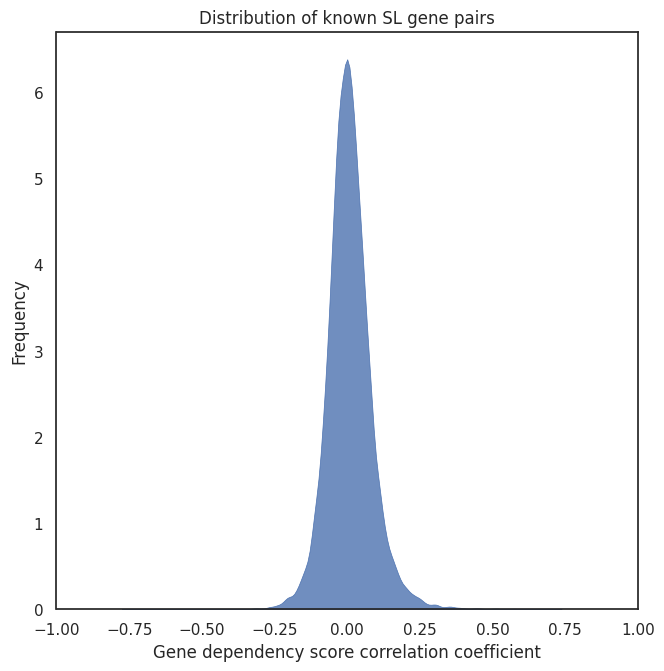

In [53]:
f,ax = plt.subplots(figsize=(7.5, 7.5))

sns.set_theme(style="white")
# Plot a histogram of the correlation
sns.kdeplot(data=sl_corr, fill=True, legend=False, linewidth=0.5,alpha=.8,color=sns.color_palette("pastel")[0])
# sns.histplot(data=sl_corr, kde=True)

# plt.hist(sl_corr, bins=100)
plt.xlabel('Gene dependency score correlation coefficient')
plt.ylabel('Frequency')
plt.title('Distribution of known SL gene pairs')
plt.xlim(-1,1)
# plt.show()

plt.savefig('sl_corr_dep_18.svg')

In [18]:
sns.color_palette('pastel')[2]

(0.5529411764705883, 0.8980392156862745, 0.6313725490196078)

In [45]:
sl_mat = sp.csc_matrix((np.ones(len(sl_label)), (sl_label['unified_id_A'], sl_label['unified_id_B'])), shape=(9845, 9845))
sl_mat = sl_mat+sl_mat.T
sl_mat = sl_mat.toarray()
neg_mat = np.ones((9845, 9845))
neg_wo_sl_mat = neg_mat - sl_mat
neg_wo_sl_up = np.triu(neg_wo_sl_mat,k=1)
neg_wo_sl_up = sp.csc_matrix(neg_wo_sl_up*abs(DepMap_Effect_corr.values))
neg_ids = np.vstack(neg_wo_sl_up.nonzero()).T
corr_scores = np.asarray(abs(DepMap_Effect_corr.values))[neg_ids[:,0],neg_ids[:,1]]
neg_ids_scores = np.vstack([neg_ids.T,corr_scores]).T
sorted_indices = np.argsort(neg_ids_scores[:, 2])[::-1]
sorted_neg_ids_scores = neg_ids_scores[sorted_indices]
sorted_neg_ids_scores

array([[9.844e+03, 9.841e+03,       nan],
       [2.398e+03, 1.750e+03,       nan],
       [2.398e+03, 2.526e+03,       nan],
       ...,
       [8.170e+02, 6.315e+03, 1.000e-06],
       [1.409e+03, 6.422e+03, 1.000e-06],
       [1.449e+03, 3.136e+03, 1.000e-06]])

In [46]:
sorted_neg_ids_scores = sorted_neg_ids_scores[~np.isnan(sorted_neg_ids_scores[:,2])]

In [58]:
np.save('sorted_neg_ids_scores_dep.npy',sorted_neg_ids_scores)

In [47]:
contained_genes = set()
contained_neg_pairs_index = []
index_neg_pair = 0
while len(contained_genes) < 9529:
    if len(set(sorted_neg_ids_scores[index_neg_pair, :2]) & contained_genes) < 2:
        contained_neg_pairs_index.append(index_neg_pair)
        contained_genes = contained_genes | set(sorted_neg_ids_scores[index_neg_pair, :2])
    index_neg_pair+=1

In [49]:
# sorted_neg_ids_scores[index_neg_pair,:]
top5 = sorted_neg_ids_scores[contained_neg_pairs_index[-5:],:]
top5 = pd.DataFrame(top5,columns=['unified_id_A','unified_id_B','corr_score'])
top5['symbol_A'] = top5['unified_id_A'].map(meta_table.set_index('unified_id')['symbol'])
top5['symbol_B'] = top5['unified_id_B'].map(meta_table.set_index('unified_id')['symbol'])
top5

,unified_id_A,unified_id_B,corr_score,symbol_A,symbol_B
0,5818.0,7034.0,0.149501,TMEM131L,CAPN7
1,4621.0,8378.0,0.149187,DDX60,HAND2
2,6489.0,6496.0,0.148429,RAD54L2,IGHMBP2
3,652.0,8127.0,0.144051,HLTF,PCDHB14
4,4373.0,4855.0,0.142029,RPS10,SNRPB


In [37]:
contained_neg_pairs_index[:5]
len(sorted_neg_ids_scores)

45361285

In [73]:
one_time_neg_index = copy.deepcopy(contained_neg_pairs_index)
index_neg_pair = 0
while len(one_time_neg_index) < len(sl_label):
    if index_neg_pair not in contained_neg_pairs_index:
        one_time_neg_index.append(index_neg_pair)
    index_neg_pair+=1
print(len(one_time_neg_index))
# index_neg_pair = 0
five_time_neg_index = copy.deepcopy(one_time_neg_index)
while len(five_time_neg_index) < len(sl_label)*5:
    if index_neg_pair not in contained_neg_pairs_index:
        five_time_neg_index.append(index_neg_pair)
    index_neg_pair+=1
print(len(five_time_neg_index))
# index_neg_pair = 0
twinty_time_neg_index = copy.deepcopy(five_time_neg_index)
while len(twinty_time_neg_index) < len(sl_label)*20:
    if index_neg_pair not in contained_neg_pairs_index:
        twinty_time_neg_index.append(index_neg_pair)
    index_neg_pair+=1
print(len(twinty_time_neg_index))
# index_neg_pair = 0
fifty_time_neg_index = copy.deepcopy(twinty_time_neg_index)
while len(fifty_time_neg_index) < len(sl_label)*50:
    if index_neg_pair not in contained_neg_pairs_index:
        fifty_time_neg_index.append(index_neg_pair)
    index_neg_pair+=1
print(len(fifty_time_neg_index))

35913
179565
718260
1795650


In [74]:
np.save('one_time_neg_index_dep.npy', one_time_neg_index)
np.save('five_time_neg_index_dep.npy', five_time_neg_index)
np.save('twenty_time_neg_index_dep.npy', twinty_time_neg_index)
np.save('fifty_time_neg_index_dep.npy', fifty_time_neg_index)

In [77]:
sorted_neg_ids_scores[one_time_neg_index,:2]

array([[2291., 6095.],
       [3515., 4938.],
       [4938., 7558.],
       ...,
       [1662., 4867.],
       [2396., 3471.],
       [4717., 5234.]])